<a href="https://colab.research.google.com/github/nityamshah/datascience/blob/main/NityShahU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

# Greenhouse Gas Emissions by Population

I chose to look at a dataset that compares greenhouse gas emissions per 100k people and population in ten millions of ten different countries overtime. One thing that's interesting about this set of data is that without taking year into account the population data still hold information about time. This data spans from 1970 to 2012.

I begun by plotting the data.

In [ ]:
#load the data into a pandas dataframe, and print it
url_greenhouse = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/greenhousegas_pop_10nations.csv'
greenhouse = pd.read_csv(url_greenhouse)

In [ ]:
greenhouse

,country,code,year,grnGasEm100K,pop10M
0,Brazil,BRA,1970,12.6098,9.5982
1,Canada,CAN,1970,4.9497,2.1324
2,China,CHN,1970,18.7397,81.8315
3,Germany,DEU,1970,12.8657,7.8169
4,France,FRA,1970,6.1450,5.2035
...,...,...,...,...,...
425,United Kingdom,GBR,2012,5.8578,6.3700
426,India,IND,2012,30.0289,126.3590
427,Japan,JPN,2012,14.7886,12.7561
428,Mexico,MEX,2012,6.6342,12.2071


<Axes: xlabel='pop10M', ylabel='grnGasEm100K'>

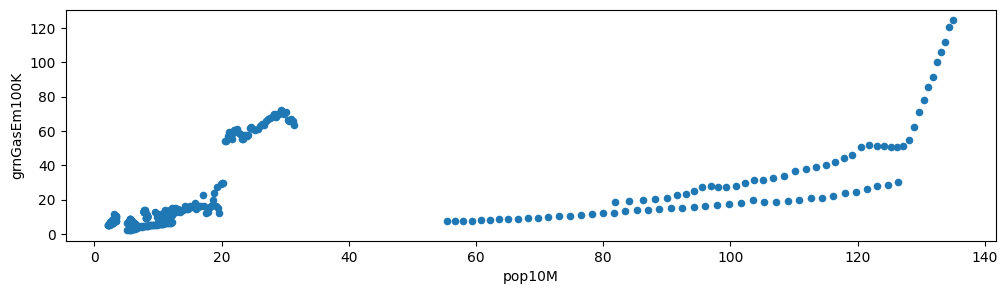

In [ ]:
greenhouse.plot(x="pop10M", y="grnGasEm100K", figsize=(12, 3), kind="scatter")

Since this data is all the countries it looks a little wonky and clumped with two lines for India and China on the right. This doesn't make too much sense to model because each country has its own greenhouse gas policies and efforts. To get around this, I plotted each country individually to pick an interesting one to model.

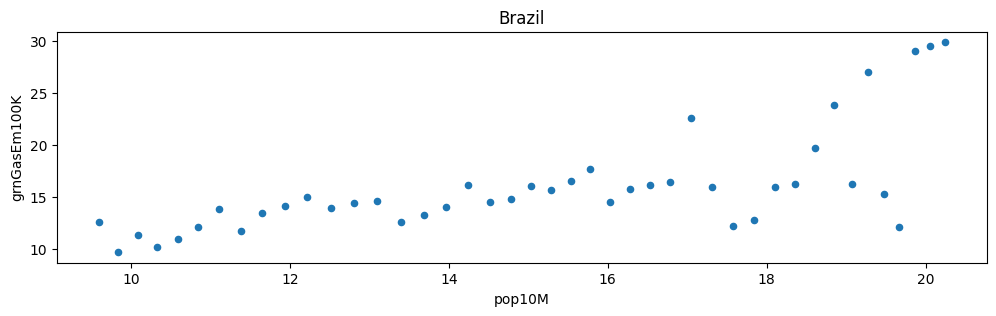

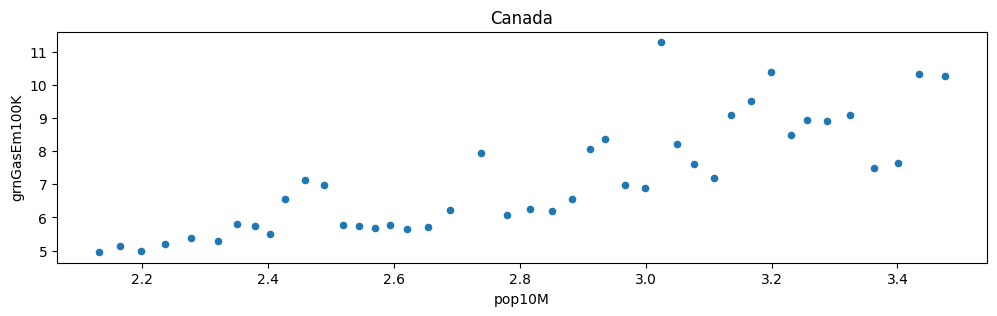

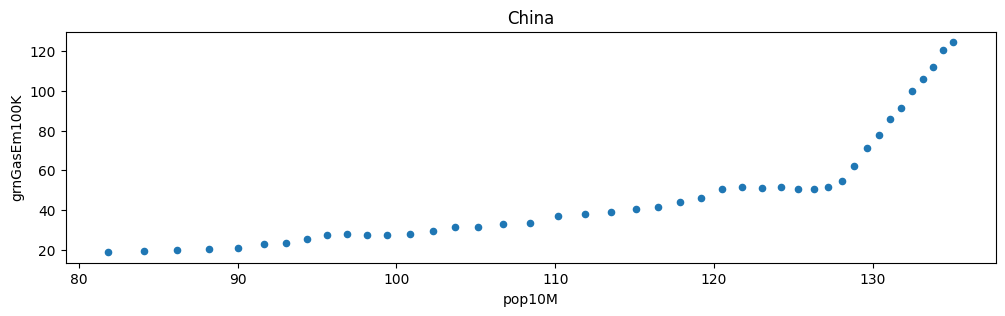

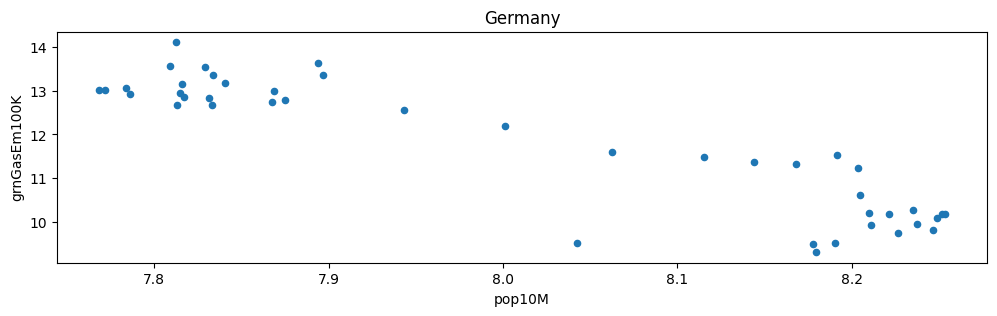

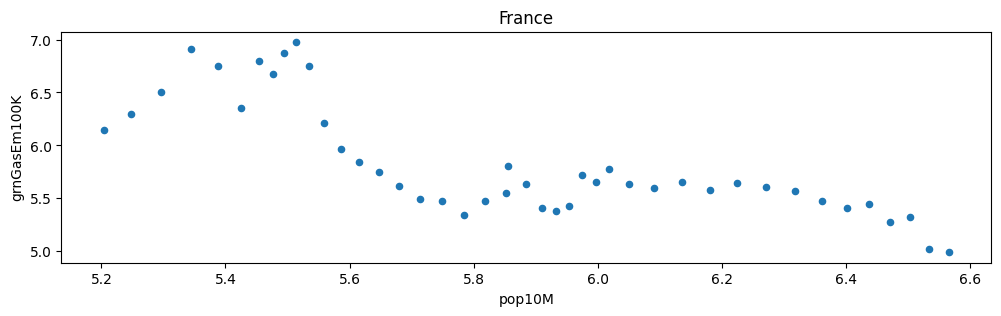

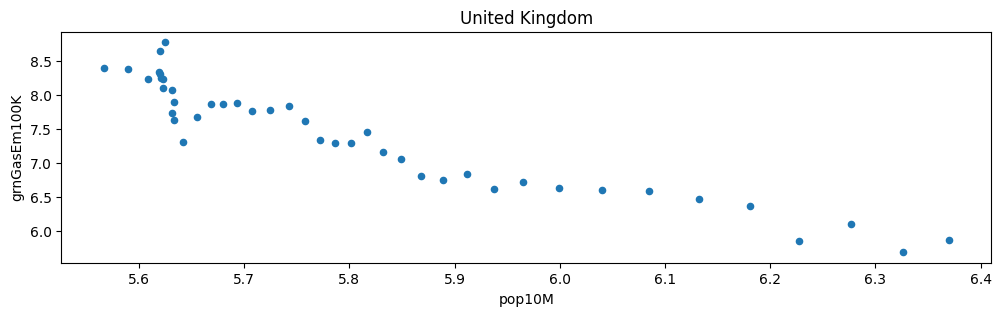

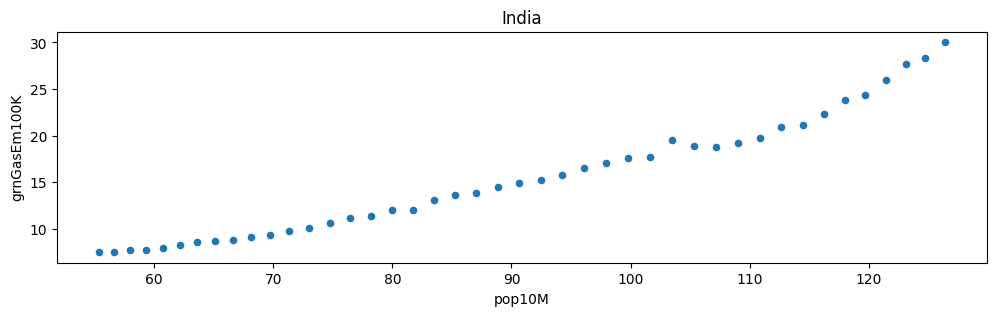

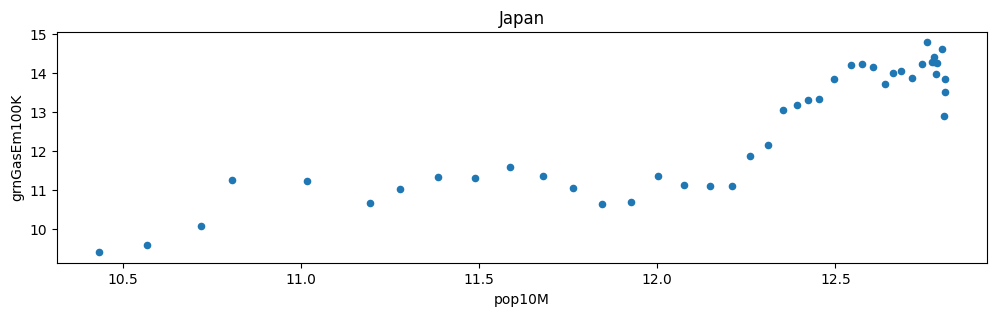

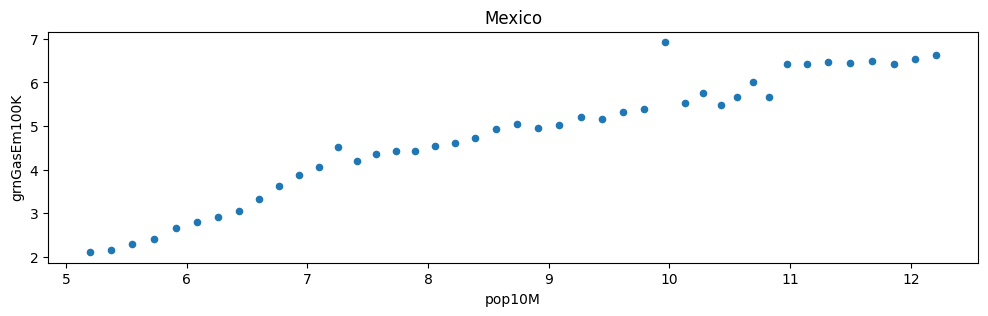

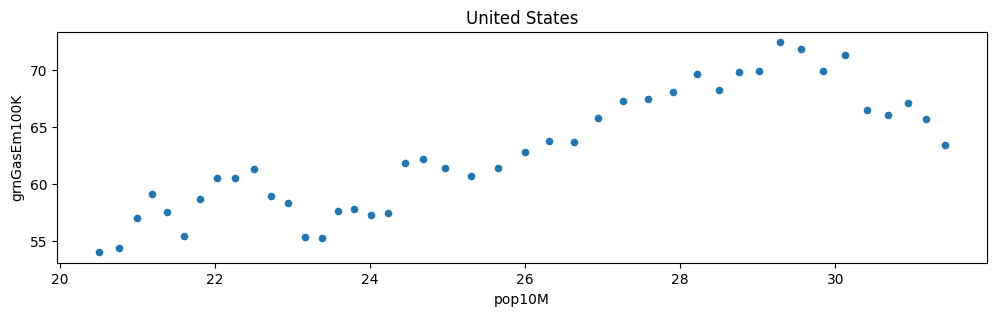

In [ ]:
Countries = ['Brazil', 'Canada', 'China', 'Germany', 'France', 'United Kingdom', 'India', 'Japan', 'Mexico', 'United States']
for x in range(10):
  country = Countries[x]
  greenhouseCountry = greenhouse.query('country == @country')
  greenhouseCountry.plot(x="pop10M", y="grnGasEm100K", figsize=(12, 3), kind="scatter", title = country)

I settled on the UK because I thought it was interesting how it was one of the few countries in this set that has lower emissions with population/time. Upon further research we can see that this checks out because the UK is working to lower greenhouse gas emissions. Below are the plots of the UK data.

,country,code,year,grnGasEm100K,pop10M
5,United Kingdom,GBR,1970,8.3959,5.5663
15,United Kingdom,GBR,1971,8.3741,5.5896
25,United Kingdom,GBR,1972,8.2215,5.6086
35,United Kingdom,GBR,1973,8.6334,5.6195
45,United Kingdom,GBR,1974,8.2352,5.6230
55,United Kingdom,GBR,1975,8.0942,5.6226
65,United Kingdom,GBR,1976,8.2466,5.6212
75,United Kingdom,GBR,1977,8.3352,5.6193
85,United Kingdom,GBR,1978,8.3054,5.6197
95,United Kingdom,GBR,1979,8.7695,5.6247


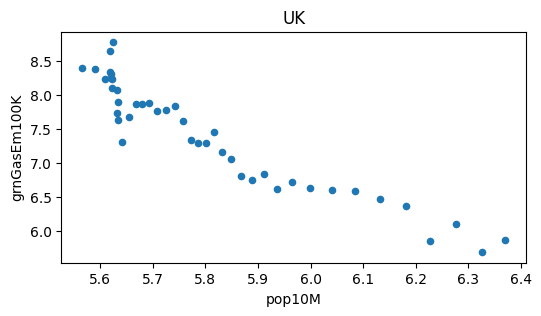

In [ ]:
greenhouseUK = greenhouse.query('country == "United Kingdom"')
greenhouseUK.plot(x="pop10M", y="grnGasEm100K", figsize=(6, 3), kind="scatter", title = "UK")
greenhouseUK

<Axes: ylabel='pop10M'>

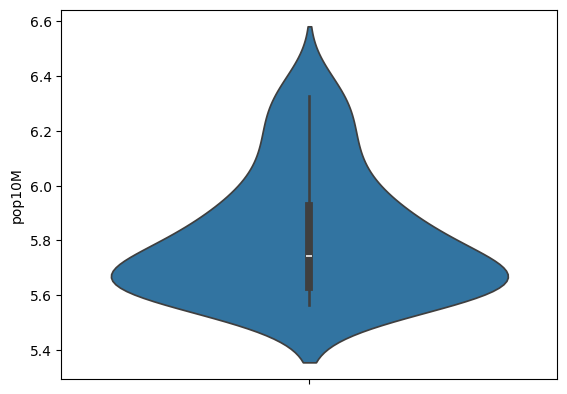

In [ ]:
sns.violinplot(greenhouseUK.pop10M)

I begun with a simple linear model with normal priors and a normal likelihood.

In [ ]:
with pm.Model() as model_greenhouse:

    #priors for our mean line
    #the default mean for a normal dist is 0
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * greenhouseUK.pop10M)

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=greenhouseUK.grnGasEm100K)

    idata_greenhouse = pm.sample()

Output()

Output()

Text(0, 0.5, 'grnGasEm100K')

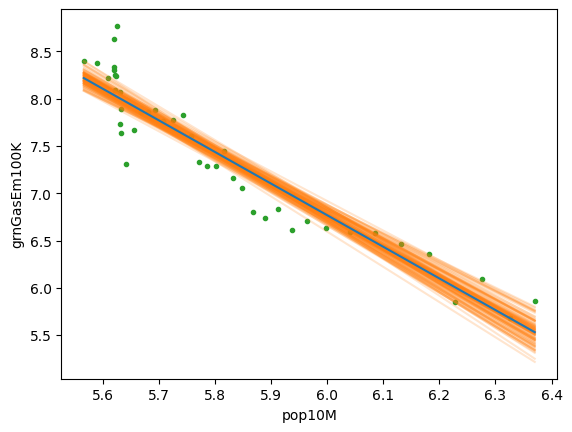

In [ ]:
#grabs 100 posterior samples
posterior = az.extract(idata_greenhouse, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(greenhouseUK.pop10M.min(), greenhouseUK.pop10M.max(), 50),
    dims="plot_id"
    )

# this creates the expected line
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(greenhouseUK.pop10M, greenhouseUK.grnGasEm100K, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("pop10M")
ax.set_ylabel("grnGasEm100K")

This posterior is okay. It generally follows the same linear trend as the data but misses a lot near the beginning and middle.

Output()

<Axes: xlabel='y_pred'>

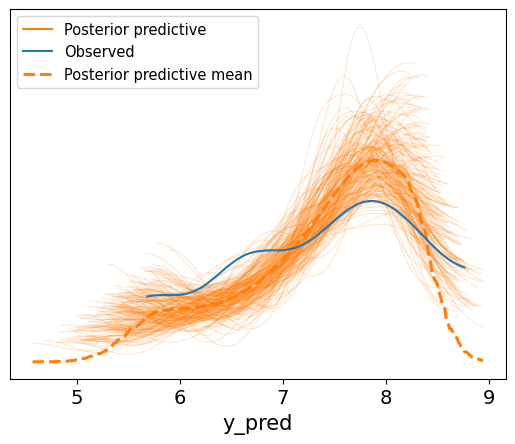

In [ ]:
pm.sample_posterior_predictive(
    idata_greenhouse, model = model_greenhouse, extend_inferencedata=True
    )

#posterior predictive check
az.plot_ppc(idata_greenhouse, num_pp_samples=200, colors=["C1", "C0", "C1"])

Text(0, 0.5, 'grnGasEm100K')

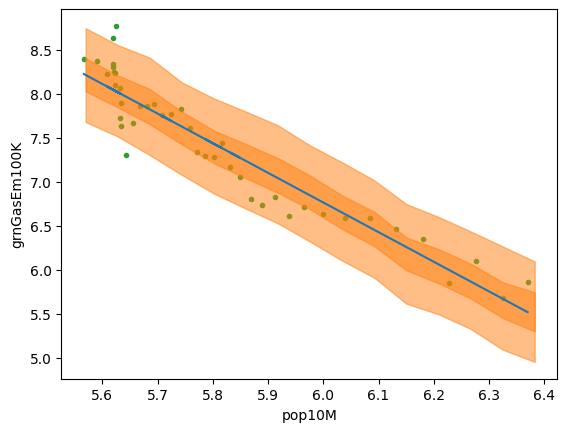

In [ ]:
#plots the posterior predictive distribution

greenhouseUK = greenhouseUK.reset_index(drop=True)

#grabs the expected line, or line of best fit formula
mean_line = idata_greenhouse.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
pop10M = np.random.normal(greenhouseUK.pop10M.values, 0.01)
#idx = np.argsort(greenhouseUK.pop10M.values)
idx = np.argsort(pop10M)
x = np.linspace(pop10M.min(), pop10M.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_greenhouse.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(pop10M[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(greenhouseUK.pop10M, greenhouseUK.grnGasEm100K, "C2.", zorder=-3)
ax.plot(greenhouseUK.pop10M[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("pop10M")
ax.set_ylabel("grnGasEm100K")

My posterior predictive checks show that it's a poor fit. So I'm trying again.

## Exponential and StudentT

Model is not capturing variation near the top left or the bit of curve near the middle very well. This variation is around 1970-1985 data points. During this time there was a bit of industrial decline and some economic recession that can explain the lower greenhouse gas emissions than expected of the time. Some unusally high emissions are also seen possibly from growth in transportation or increased coal reliance during oil crises in 1973 and 1979. To capture these we can try a StudentT model because it expects outliers or curves (exponential).

Below is a StudentT model

In [ ]:
with pm.Model() as model_T:

    #priors for our mean line
    #the default mean for a normal dist is 0
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * greenhouseUK.pop10M)

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    𝜈 = pm.Exponential('nu', lam=3)

    #normal likelihood
    y_pred = pm.StudentT("y_pred", nu=𝜈, mu=μ, sigma=σ, observed=greenhouseUK.grnGasEm100K)

    idata_T = pm.sample()

Output()

Output()

Text(0, 0.5, 'grnGasEm100K')

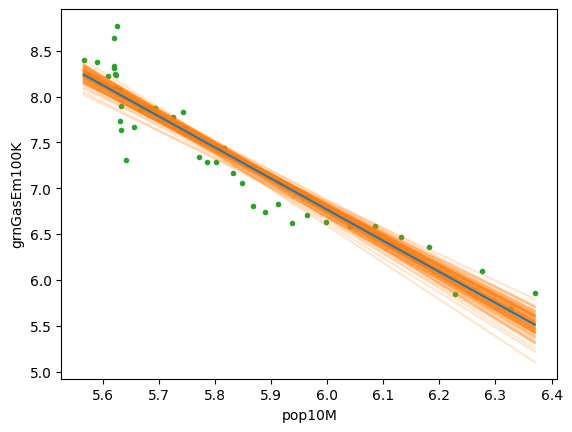

In [ ]:
#grabs 100 posterior samples
posterior = az.extract(idata_T, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(greenhouseUK.pop10M.min(), greenhouseUK.pop10M.max(), 50),
    dims="plot_id"
    )

# this creates the expected line
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(greenhouseUK.pop10M, greenhouseUK.grnGasEm100K, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("pop10M")
ax.set_ylabel("grnGasEm100K")

Output()

(4.0, 10.0)

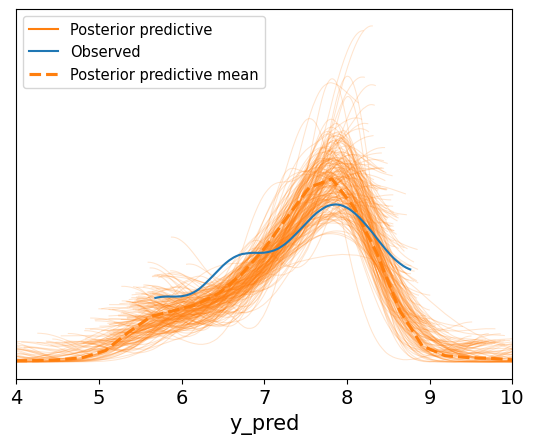

In [ ]:
pm.sample_posterior_predictive(
    idata_T, model = model_T, extend_inferencedata=True
    )

#posterior predictive check
ax = az.plot_ppc(idata_T, num_pp_samples=200, colors=["C1", "C0", "C1"])
ax.set_xlim(4, 10)

Text(0, 0.5, 'grnGasEm100K')

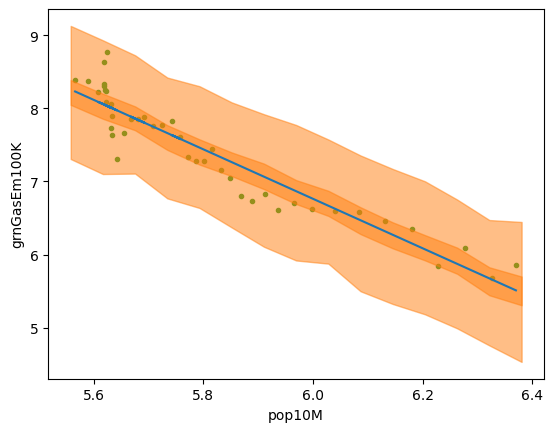

In [ ]:
#plots the posterior predictive distribution

greenhouseUK = greenhouseUK.reset_index(drop=True)

#grabs the expected line, or line of best fit formula
mean_line = idata_T.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
pop10M = np.random.normal(greenhouseUK.pop10M.values, 0.01)
#idx = np.argsort(greenhouseUK.pop10M.values)
idx = np.argsort(pop10M)
x = np.linspace(pop10M.min(), pop10M.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_T.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(pop10M[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(greenhouseUK.pop10M, greenhouseUK.grnGasEm100K, "C2.", zorder=-3)
ax.plot(greenhouseUK.pop10M[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("pop10M")
ax.set_ylabel("grnGasEm100K")

This one also looks okay, but I think that there's a bit of a curve that the model is not capturing so I'm going to try exponential.

Below is with an exponential model

In [ ]:
with pm.Model() as model_exp:

    #priors for our mean line
    #the default mean for a normal dist is 0
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", α + β * greenhouseUK.pop10M)

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    #normal likelihood
    y_pred = pm.LogNormal("y_pred", mu=μ, sigma=σ, observed=greenhouseUK.grnGasEm100K)

    idata_exp = pm.sample()

Output()

Output()

Text(0, 0.5, 'grnGasEm100K')

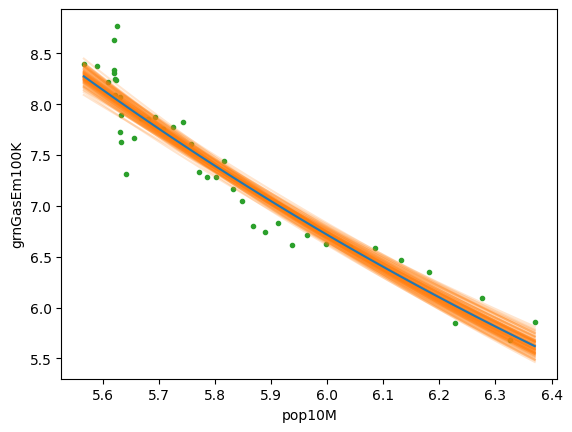

In [ ]:
#grabs 100 posterior samples
posterior = az.extract(idata_exp, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(greenhouseUK.pop10M.min(), greenhouseUK.pop10M.max(), 50),
    dims="plot_id"
    )

# this creates the expected line
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, np.exp(lines.T), c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, np.exp(mean_line), c="C0", label="mean line")

#plot the raw data
ax.plot(greenhouseUK.pop10M, greenhouseUK.grnGasEm100K, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("pop10M")
ax.set_ylabel("grnGasEm100K")

Output()

<Axes: xlabel='y_pred'>

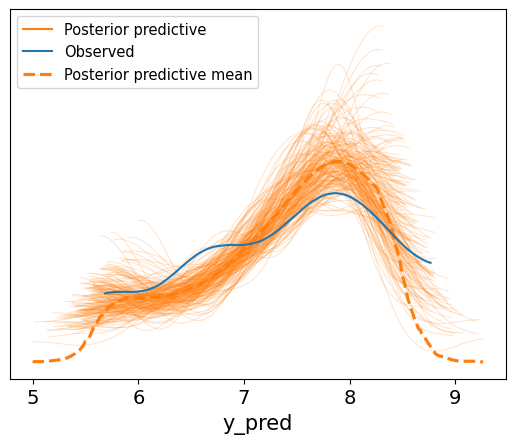

In [ ]:
pm.sample_posterior_predictive(
    idata_exp, model = model_exp, extend_inferencedata=True
    )

#posterior predictive check
az.plot_ppc(idata_exp, num_pp_samples=200, colors=["C1", "C0", "C1"])

Text(0, 0.5, 'grnGasEm100K')

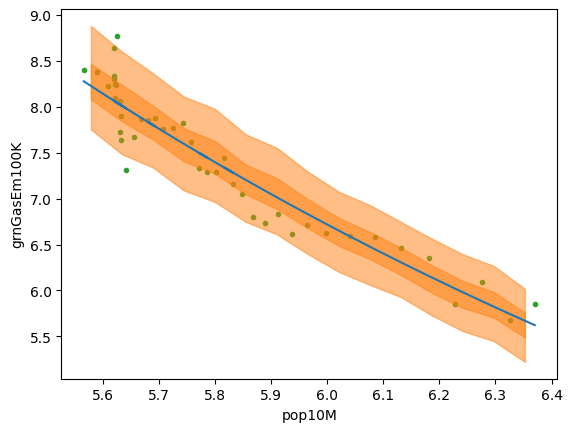

In [ ]:
#plots the posterior predictive distribution

greenhouseUK = greenhouseUK.reset_index(drop=True)

#grabs the expected line, or line of best fit formula
mean_line = idata_exp.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
pop10M = np.random.normal(greenhouseUK.pop10M.values, 0.01)
#idx = np.argsort(greenhouseUK.pop10M.values)
idx = np.argsort(pop10M)
x = np.linspace(pop10M.min(), pop10M.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_exp.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(pop10M[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(greenhouseUK.pop10M, greenhouseUK.grnGasEm100K, "C2.", zorder=-3)
ax.plot(greenhouseUK.pop10M[idx], np.exp(mean_line[idx]), c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("pop10M")
ax.set_ylabel("grnGasEm100K")

This one is definitely better and even seems to narrow near the right side. Maybe by combining Exponential and StudentT, we can get a better fit.

Below is Exponential with Student T.

In [ ]:
with pm.Model() as model_expT:

    #priors for our mean line
    #the default mean for a normal dist is 0
    α = pm.Normal("α", sigma=10)
    β = pm.Normal("β", sigma=10)

    #mean line
    μ = pm.Deterministic("μ", pm.math.exp(α + β * greenhouseUK.pop10M))

    #prior for standard deviation
    σ = pm.HalfNormal("σ", sigma = 10)

    𝜈 = pm.Exponential('nu', lam=3)

    y_pred = pm.StudentT("y_pred", nu=𝜈, mu=μ, sigma=σ, observed=greenhouseUK.grnGasEm100K)

    idata_expT = pm.sample()

Output()

Output()

Text(0, 0.5, 'grnGasEm100K')

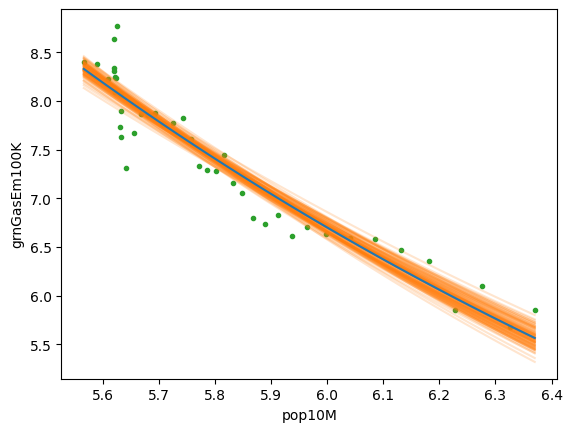

In [ ]:
#grabs 100 posterior samples
posterior = az.extract(idata_expT, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(greenhouseUK.pop10M.min(), greenhouseUK.pop10M.max(), 50),
    dims="plot_id"
    )

# this creates the expected line
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, np.exp(lines.T), c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, np.exp(mean_line), c="C0", label="mean line")

#plot the raw data
ax.plot(greenhouseUK.pop10M, greenhouseUK.grnGasEm100K, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("pop10M")
ax.set_ylabel("grnGasEm100K")

Output()

(1.0, 10.0)

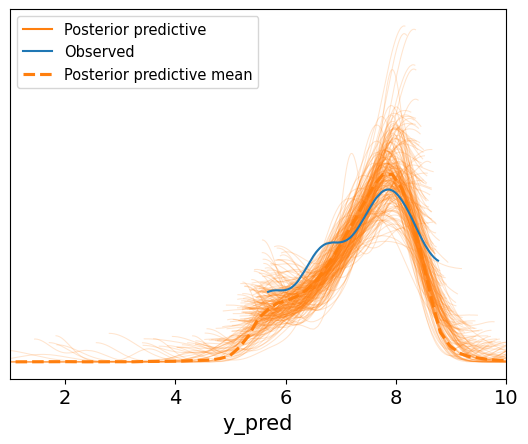

In [ ]:
pm.sample_posterior_predictive(
    idata_expT, model = model_expT, extend_inferencedata=True
    )

#posterior predictive check
ax = az.plot_ppc(idata_expT, num_pp_samples=200, colors=["C1", "C0", "C1"])
ax.set_xlim(1, 10)

Text(0, 0.5, 'grnGasEm100K')

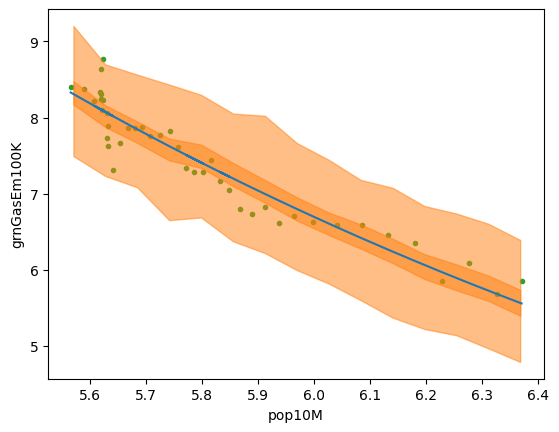

In [ ]:
#plots the posterior predictive distribution

greenhouseUK = greenhouseUK.reset_index(drop=True)

#grabs the expected line, or line of best fit formula
mean_line = idata_expT.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
pop10M = np.random.normal(greenhouseUK.pop10M.values, 0.01)
#idx = np.argsort(greenhouseUK.pop10M.values)
idx = np.argsort(pop10M)
x = np.linspace(pop10M.min(), pop10M.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_expT.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(pop10M[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(greenhouseUK.pop10M, greenhouseUK.grnGasEm100K, "C2.", zorder=-3)
ax.plot(greenhouseUK.pop10M[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("pop10M")
ax.set_ylabel("grnGasEm100K")

Although not perfect, this model is a lot better and follows the data better. It makes sense because the StudentT allows it to expect outliers at lower populations which align with the context I found earlier about the UKs economy in the 70s and 80s, but the exponential allows it to capture the curve too.